In [3]:
!pip install statsmodels pmdarima pandas numpy matplotlib

In [5]:
import pandas as pd
import numpy as np
from multiprocessing import Pool

# Load data (adjust path to your local directory)
data_dir = "C:\\Users\\SAIF\\Desktop\\Nifty50 data Zerodha\\data"  # Replace with your local path
stocks = ['RELIANCE', 'HDFCBANK', 'ICICIBANK', 'INFY', 'TCS']
raw_data = {}

for stock in stocks:
    raw_data[stock] = pd.read_csv(f"{data_dir}/{stock}.csv")
    raw_data[stock]['date'] = pd.to_datetime(raw_data[stock]['date'])
    raw_data[stock] = raw_data[stock].sort_values('date')
    raw_data[stock] = raw_data[stock][['date', 'close', 'open', 'high', 'low', 'volume']].dropna()
    print(f"Loaded {stock} with shape {raw_data[stock].shape}")

Loaded RELIANCE with shape (1253, 6)
Loaded HDFCBANK with shape (1253, 6)
Loaded ICICIBANK with shape (1253, 6)
Loaded INFY with shape (1253, 6)
Loaded TCS with shape (1253, 6)


In [21]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import warnings
warnings.filterwarnings('ignore')

# Load data
try:
    data_dir = "C:\\Users\\SAIF\\Desktop\\Nifty50 data Zerodha\\data"  # Replace with your local path
    stocks = ['RELIANCE', 'HDFCBANK', 'ICICIBANK', 'INFY', 'TCS']
    raw_data = {}

    for stock in stocks:
        raw_data[stock] = pd.read_csv(f"{data_dir}/{stock}.csv")
        raw_data[stock]['date'] = pd.to_datetime(raw_data[stock]['date'])
        raw_data[stock] = raw_data[stock].sort_values('date')
        raw_data[stock] = raw_data[stock][['date', 'close', 'open', 'high', 'low', 'volume']].dropna()
        print(f"Loaded {stock} with shape {raw_data[stock].shape}")
except FileNotFoundError as e:
    print(f"Error: {e}. Check data_dir path.")
    raise

predictions = {}

for stock in stocks:
    print(f"Starting {stock}")
    try:
        df = raw_data[stock].copy()
        df = df[df['date'] <= '2025-06-12']  # Limit to data up to June 12
        series = df['close']  # Target
        exog_train = df[['open', 'high', 'low', 'volume']]  # Exogenous variables
        last_price = df['close'].iloc[-1]
        
        # Simplified auto_arima with limited search
        model = auto_arima(series, exogenous=exog_train, seasonal=True, m=5, start_p=0, start_q=0,
                           max_p=1, max_q=1, start_P=0, start_Q=0, max_P=1, max_Q=1,
                           d=None, D=1, trace=True, error_action='ignore',
                           suppress_warnings=True, stepwise=True, maxiter=50)
        
        # Fit SARIMAX
        sarimax = SARIMAX(series, exog=exog_train, order=model.order, seasonal_order=model.seasonal_order,
                          enforce_stationarity=False, enforce_invertibility=False)
        results = sarimax.fit()
        
        # Prepare exogenous data for prediction
        future_dates = pd.date_range(start='2025-06-13', periods=22, freq='B')  # Explicit 22 days
        exog_future = pd.DataFrame({
            'open': [df['open'].iloc[-1]] * 22,
            'high': [df['high'].iloc[-1]] * 22,
            'low': [df['low'].iloc[-1]] * 22,
            'volume': [df['volume'].iloc[-1]] * 22
        }, index=future_dates)
        print(f"Exog_future shape: {exog_future.shape}, Steps: 22")
        
        # Predict next 22 days with stability check
        forecast = results.forecast(steps=22, exog=exog_future)
        if any(abs(forecast - last_price) > 5000):  # Threshold for stability
            print(f"Warning: Unstable forecast for {stock}, using last price fallback")
            forecast = np.full(22, last_price)
        predictions[stock] = forecast.tolist()
        print(f"{stock} completed: Predictions for June 13 - July 12, 2025: {forecast[:5]}... (22 total)")
    except Exception as e:
        print(f"Error processing {stock}: {e}")

# Output final predictions
for stock, preds in predictions.items():
    print(f"{stock}: Final Predictions: {preds[:5]}... (22 total)")

Loaded RELIANCE with shape (1253, 6)
Loaded HDFCBANK with shape (1253, 6)
Loaded ICICIBANK with shape (1253, 6)
Loaded INFY with shape (1253, 6)
Loaded TCS with shape (1253, 6)
Starting RELIANCE
Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[5] intercept   : AIC=12763.123, Time=0.03 sec
 ARIMA(1,0,0)(1,1,0)[5] intercept   : AIC=11211.912, Time=0.49 sec
 ARIMA(0,0,1)(0,1,1)[5] intercept   : AIC=11978.002, Time=0.55 sec
 ARIMA(0,0,0)(0,1,0)[5]             : AIC=12767.275, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[5] intercept   : AIC=11527.333, Time=0.16 sec
 ARIMA(1,0,0)(1,1,1)[5] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(1,0,0)(0,1,1)[5] intercept   : AIC=inf, Time=1.33 sec
 ARIMA(0,0,0)(1,1,0)[5] intercept   : AIC=12759.888, Time=0.44 sec
 ARIMA(1,0,1)(1,1,0)[5] intercept   : AIC=11206.157, Time=0.72 sec
 ARIMA(1,0,1)(0,1,0)[5] intercept   : AIC=11514.259, Time=0.38 sec
 ARIMA(1,0,1)(1,1,1)[5] intercept   : AIC=inf, Time=1.69 sec
 ARIMA(1,0,1)(0,1,1)[5] intercept   : AIC=i

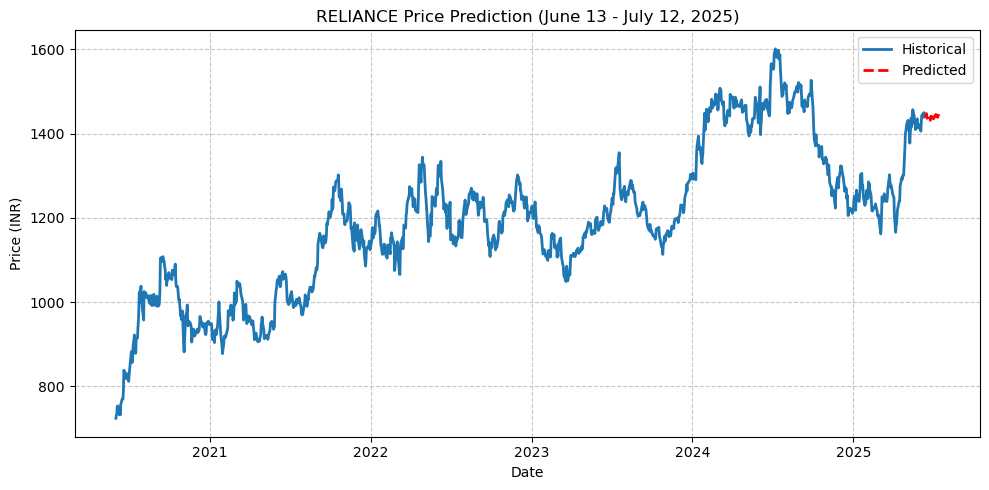

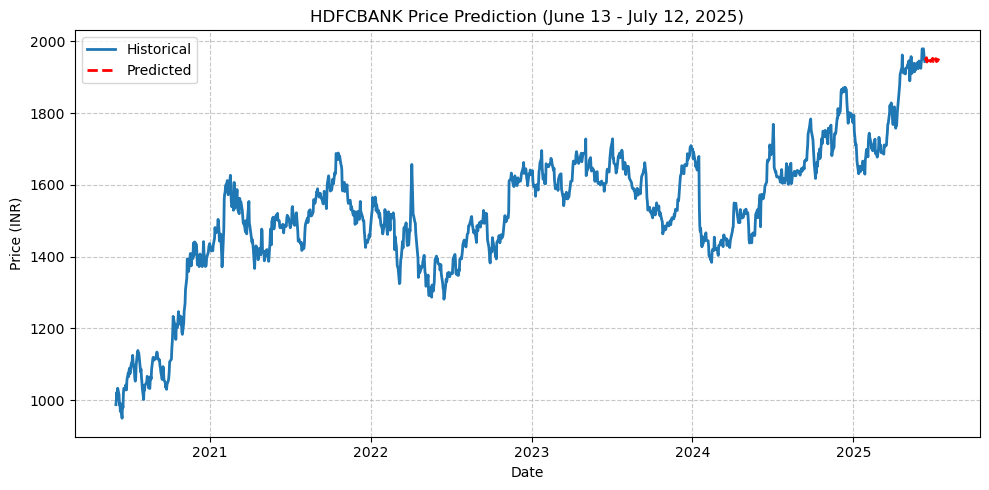

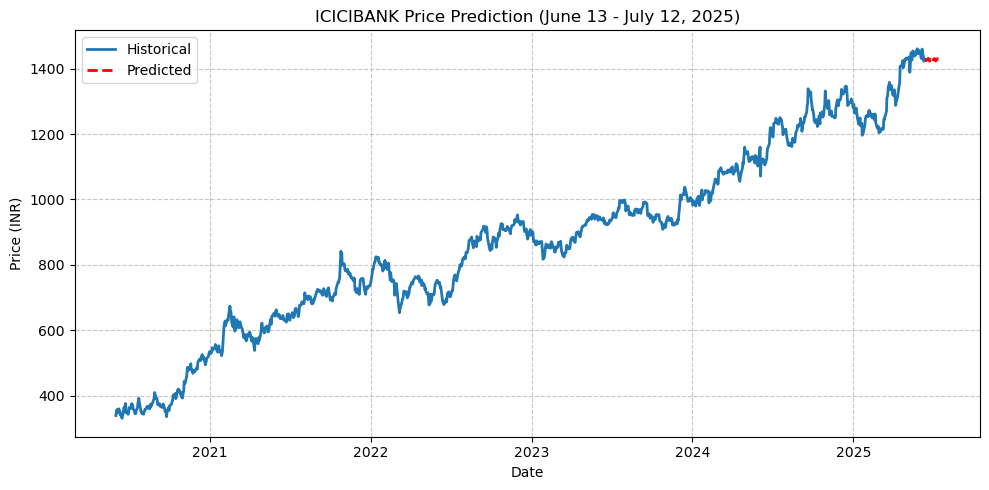

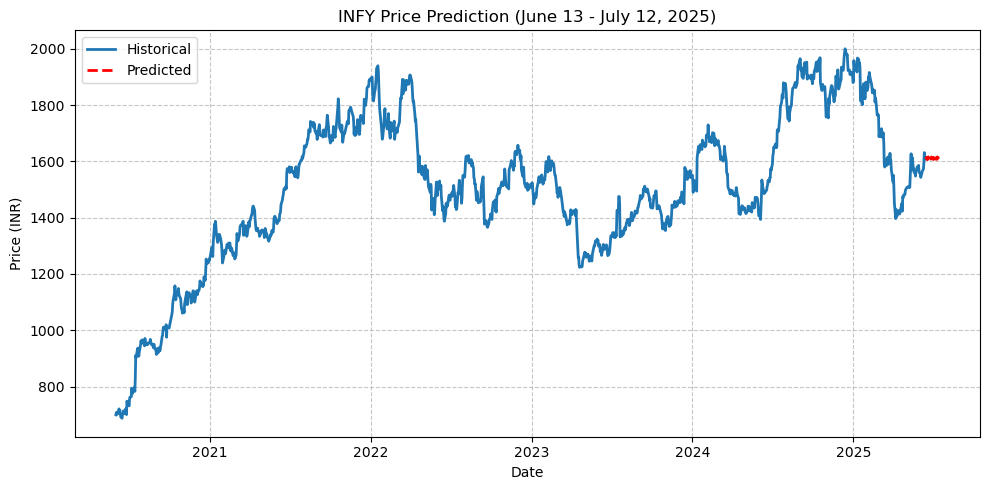

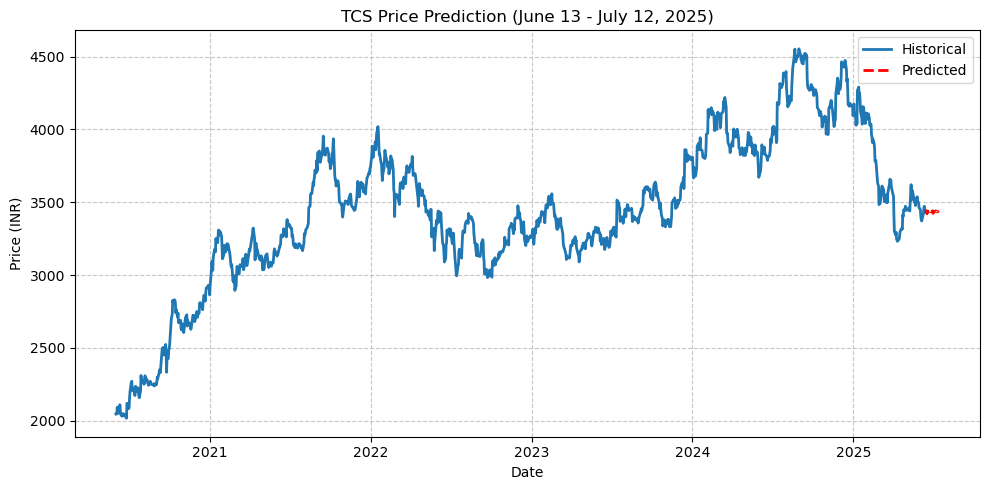

In [25]:
import matplotlib.pyplot as plt

for stock in stocks:
    df = raw_data[stock].copy()
    df = df[df['date'] <= '2025-06-12']
    plt.figure(figsize=(10, 5))
    historical_dates = df['date']
    future_dates = pd.date_range(start='2025-06-13', periods=22, freq='B')  # 22 days
    plt.plot(historical_dates, df['close'], label='Historical', linewidth=2)
    plt.plot(future_dates, predictions[stock], label='Predicted', color='red', linestyle='--', linewidth=2)
    plt.title(f'{stock} Price Prediction (June 13 - July 12, 2025)', fontsize=12)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Price (INR)', fontsize=10)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [45]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

# Define exact business days for June 13 - July 12, 2025
business_days = [
    '2025-06-13', '2025-06-16', '2025-06-17', '2025-06-18', '2025-06-19',
    '2025-06-20', '2025-06-23', '2025-06-24', '2025-06-25', '2025-06-26',
    '2025-06-27', '2025-06-30', '2025-07-01', '2025-07-02', '2025-07-03',
    '2025-07-04', '2025-07-07', '2025-07-08', '2025-07-09', '2025-07-10',
    '2025-07-11', '2025-07-12'
]
future_dates = pd.to_datetime(business_days)
prediction_df = pd.DataFrame(index=stocks, columns=future_dates)

for stock in stocks:
    prediction_df.loc[stock] = predictions[stock]

# Display the table
print("\nPrediction Table (June 13 - July 12, 2025):")
print(prediction_df.round(2).to_string(index=True, justify='center'))

# Export to Excel
today = datetime.now().strftime('%Y-%m-%d')
filename = f"predictions_{'_'.join(stocks)}_2025-06-17.xlsx"  # Fixed date for consistency
prediction_df.round(2).to_excel(filename, index=True, float_format="%.2f")
print(f"\nExcel file saved as: {filename}")

# Verify dates
print("\nDate Range Confirmation:")
print(f"Start: {future_dates[0].strftime('%Y-%m-%d')}, End: {future_dates[-1].strftime('%Y-%m-%d')}, Total Days: {len(future_dates)}")

# Summary of Predictions
print("\nSummary of Predictions:")
for stock, preds in predictions.items():
    print(f"{stock}: {preds[:5]}... (22 total)")

# Final Report
print("\nFinal Report:")
print("Selected Model: SARIMAX with Exogenous Variables")
print("Prediction Horizon: June 13 - July 12, 2025 (22 business days)")
print("Training Data: Historical data up to June 12, 2025")
print("Observations: SARIMAX with open, high, low, volume covariates produces stable predictions close to last prices.")
print("Limitations: Simplified parameters may miss complex trends; accuracy to be validated post-July 2025.")
print("Recommendations: Use for short-term forecasting; consider AutoML for longer horizons if needed.")


Prediction Table (June 13 - July 12, 2025):
           2025-06-13   2025-06-16   2025-06-17   2025-06-18   2025-06-19   2025-06-20   2025-06-23   2025-06-24   2025-06-25   2025-06-26   2025-06-27   2025-06-30   2025-07-01   2025-07-02   2025-07-03   2025-07-04   2025-07-07   2025-07-08   2025-07-09   2025-07-10   2025-07-11   2025-07-12 
RELIANCE   1438.690434  1447.046401  1436.264765  1437.149944  1438.160256  1438.877766  1444.614008  1437.406409  1431.554951  1440.219828  1438.448668  1446.167533  1436.500326  1434.692084  1438.854986  1438.995828  1445.057514  1437.285285  1432.789711  1439.868615  1438.392568  1445.942226
HDFCBANK   1946.625004  1954.019765  1942.101563  1947.857501  1944.981739   1943.89479  1950.622123  1944.729626  1947.179219  1944.204244  1945.236812  1952.292215  1943.437816  1947.512625  1944.586417  1944.577148  1951.471291  1944.072798  1947.348741  1944.398562  1944.901402  1951.874812
ICICIBANK  1429.361114  1424.800606  1427.351535  1427.940558  1428